In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Basic Understanding of Raytracing

![](https://gfxspeak.com/wp-content/uploads/2020/09/Levels-RT-001.png)

### Camera
- This is the origin of the rays
### Viewport
- The field of view of the camera
- What we acutally see on our display
- Rasterized in pixels
### Scene Object
- Sphere for example
- If ray hits object:
    - Reflection
    - Transmission
    - Absorption (No Reflection, No Tranmission on back of object)
### Light Source
- The object that illuminates the scene
- If reflected ray hits light source the object is illuminated and consequently the pixel in the viewport
### Shadow Rays
- Nomenclature seems to be shitty here, online this refers to the reflected ray, but why call it shadow since it can hit the light source?

## Rays from viewport

In [2]:
camera = np.array([0,0,0]) # 3D origin of camera (x,y,z)

vp = np.array([1000,0,0]) # origin of viewport (x,y,z)

# viewport vectors of plane
vp_v1 = np.array([0,1,0])
vp_v2 = np.array([0,0,1])

# width height in pix
w = 1920
h = 1080

# plane
y = np.arange(-w//2, w//2)
z = np.arange(-h//2, h//2)
yy, zz = np.meshgrid(y,z)

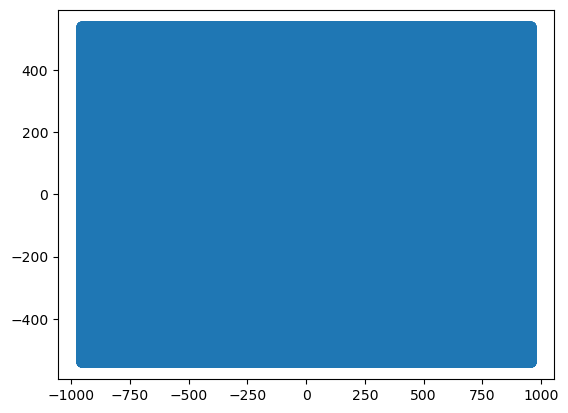

In [3]:
plt.scatter(yy,zz)

In [4]:
vp_v = vp + yy[...,None]*vp_v1 + zz[...,None]*vp_v2

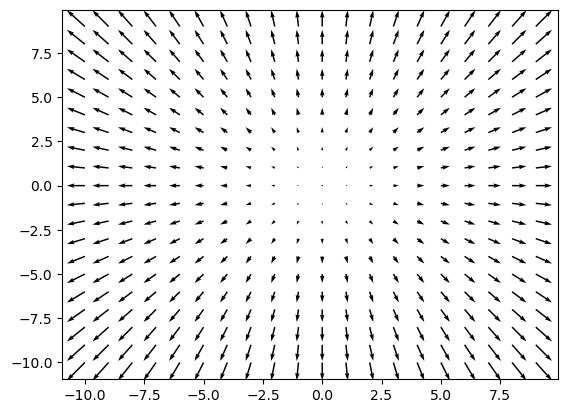

In [5]:
plt.quiver(y[w//2-10:w//2+10], z[h//2-10:h//2+10], vp_v[h//2-10:h//2+10,w//2-10:w//2+10,1], vp_v[h//2-10:h//2+10,w//2-10:w//2+10,2])

Nice! These are the vectors from origin through the viewport pixel!

## The Sphere

In [6]:
sphere = np.array([3000,0,0]) # place it aligned with camera-vp vector
radius = 600

![](https://www.scratchapixel.com/images/ray-simple-shapes/raysphereisect1.png?)

- O is origin of ray in VP
- D is the unit ray vector
- C the center of the sphere
- L the distance from O to the sphere
- We have an intersection with the sphere if d is smaller than the radius of the sphere!

We have the right triangle given by L, d and $t_{ca}$. So how do we get $t_{ca}$?

$t_{ca}$ is the projection of L on to the ray!

Wikipedia tells us [here](https://en.wikipedia.org/wiki/Vector_projection) that the projection of vector a on vector b is defined as 
$\vec{a_1} = a_1 \hat{\vec{b}}$, where $\hat{\vec{b}}$ is the unit vector along b. $a_1$ is given as

$a_1 = \vec{a}\cdot\hat{\vec{b}}$

so in our case

$\vec{t_{ca}} = (\vec{L}\cdot\hat{\vec{D}})\,\hat{\vec{D}}$

Back to d: This has now become Pythagoras!

$L^2 = \vert\vec{t_{ca}}\vert^2 + d^2$

or

$d = \sqrt{L^2 - \vert\vec{t_{ca}}\vert^2}$

Let's go!

In [7]:
l = sphere - camera

In [8]:
rays_unit = vp_v / np.linalg.norm(vp_v,axis=2)[...,None]

In [9]:
tca = np.einsum('k,ijk->ij',l,rays_unit)[...,None] * rays_unit

In [10]:
tca[0,0]

array([ 1355.50334357, -1301.28320983,  -731.97180553])

In [11]:
d = np.sqrt(np.linalg.norm(l)**2 - np.linalg.norm(tca,axis=2)**2)

In [12]:
np.sum(d<radius)

np.int64(130921)

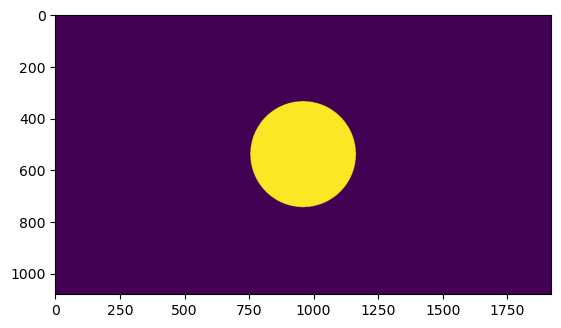

In [13]:
plt.imshow(d<=radius)

Now to calculating the intersection point alias $t_{hc}$!

This is again a right triangle with d, R (radius), and $t_{hc}$

so

$R^2 = \vert\vec{t_{hc}}\vert^2 + d^2$

or

$\vert\vec{t_{hc}}\vert = \sqrt{R^2 - d^2}$

Which leads to

$\vec{P} = (\vert\vec{t_{ca}}\vert - \vert\vec{t_{hc}}\vert) \hat{\vec{D}}$ as the vector between a viewport pixel and point P

In [14]:
# only for intersecting rays
valid = d<=radius
thcnorm = np.zeros_like(d)
thcnorm[valid] = np.sqrt(radius**2 - d[d<=radius]**2)

p = np.full_like(tca, np.nan)
p[valid] = (np.linalg.norm(tca, axis=2)[valid] - thcnorm[valid])[...,None] * rays_unit[valid]

Now it's time to calculate the contribution of a light source, I going to use Lambert's law for diffuse reflection. 
This means direct illumination for now and no furhter tracing of the ray after reflection.
Check wiki [here](https://en.wikipedia.org/wiki/Lambertian_reflectance).

First I need the normal vector of the sphere at Point P. 

$\vec{n} = \vec{P} - \vec{C}$ and then normalize it

In [217]:
n = p-sphere
n = n / np.linalg.norm(n,axis=2)[..., None]

In [218]:
light_source = np.array([1500, -500, 300])

ls_p = light_source - p
ls_p = ls_p / np.linalg.norm(ls_p, axis=2)[..., None]

diffusion_factor = np.einsum('ijk,ijk->ij', n, ls_p)
diffusion_factor[diffusion_factor<0] = 0
diffusion_factor[np.isnan(diffusion_factor)] = 0

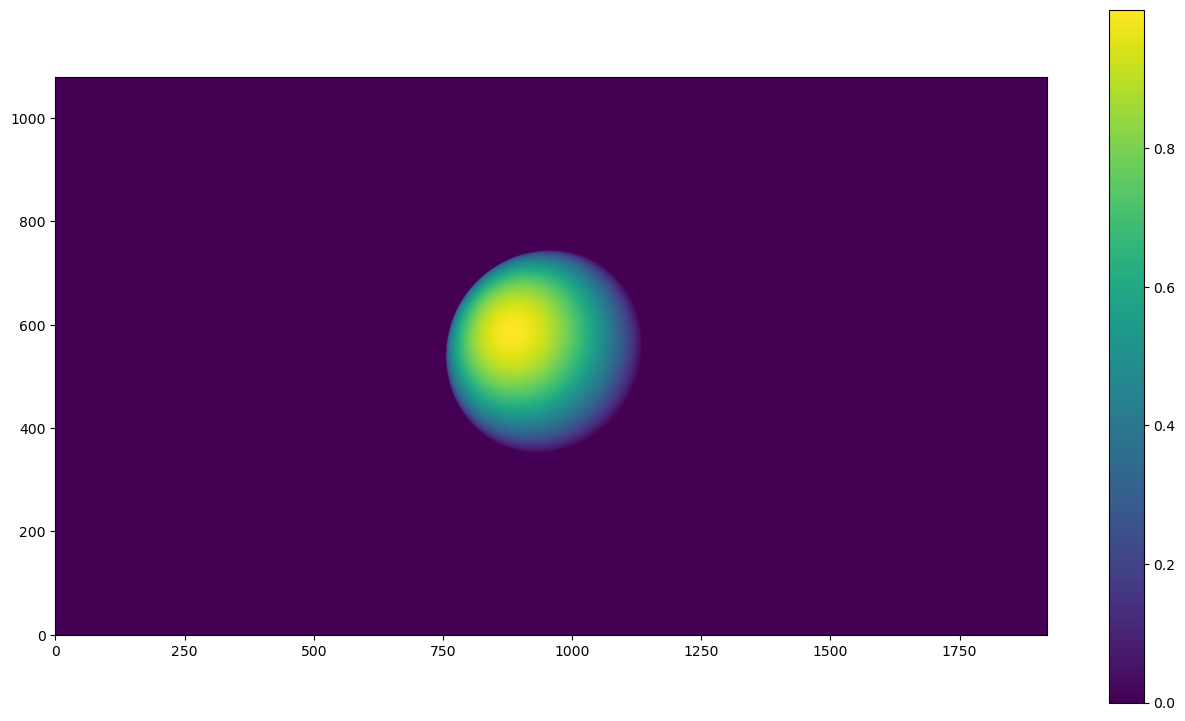

In [219]:
plt.figure(figsize=(16,9))
plt.imshow(diffusion_factor,origin='lower')
plt.colorbar()

## Let's add some texture

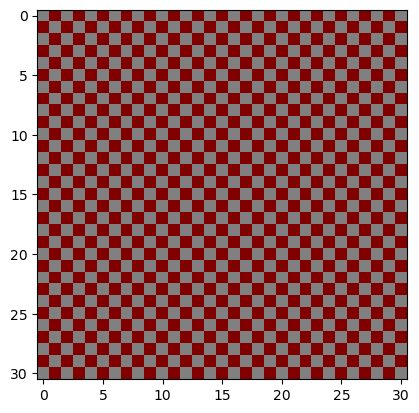

In [220]:
texture = np.ones((31,31,3), dtype=np.uint8)*128 # (r,g,b)
texture[::2,1::2, 1:3] = 0
texture[1::2,0::2, 1:3] = 0
plt.imshow(texture, interpolation=None)

Now map sphere to uv space, check wiki [here](https://en.wikipedia.org/wiki/UV_mapping)!

In [221]:
phi = np.atan2(n[...,2], n[...,0])
theta = np.arcsin(n[...,1])

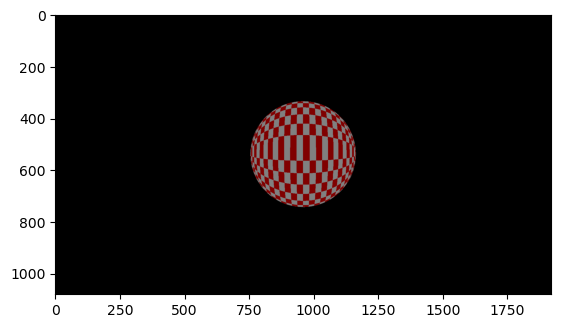

In [222]:
u = 0.5 + phi/(2*np.pi)
v = 0.5 + theta/np.pi

# convert to pix coords for texture
uu = u * texture.shape[1] - 1
vv = v * texture.shape[0] - 1

from scipy.ndimage import map_coordinates

sphere_color = np.zeros_like(n, dtype=np.uint8)
for idx in range(3):
    sphere_color[...,idx] = map_coordinates(texture[...,idx], [vv,uu], order=0, mode='reflect')
plt.imshow(sphere_color)

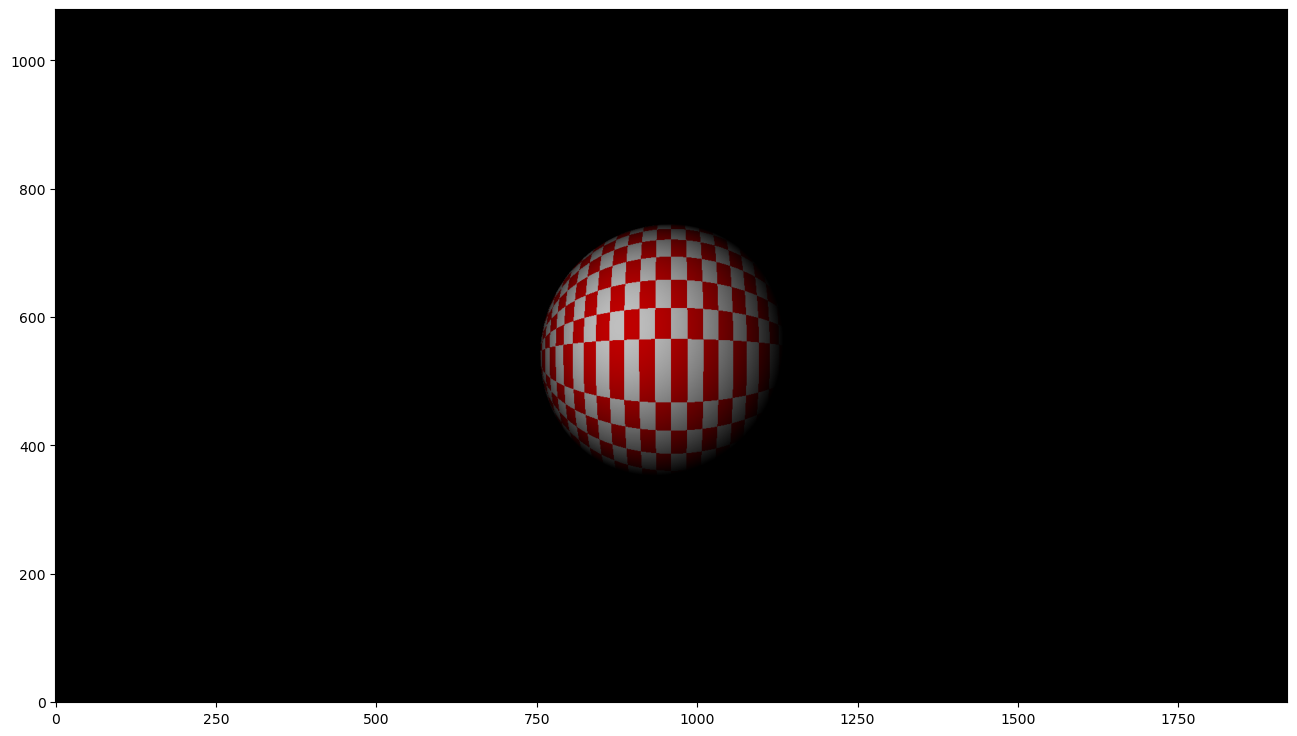

In [223]:
ls_intensity = 1.5
ambient = 0
final_color = ambient + ls_intensity * diffusion_factor[...,None]*(sphere_color-ambient)

plt.figure(figsize=(16,9))
plt.imshow(final_color.astype(np.uint8), origin='lower')

In [258]:
np.min(spec)

np.float64(0.0)

In [259]:
ref_ray = 2 * np.einsum('ijk,ijk->ij', ls_p, n)[...,None] * n - ls_p

In [260]:
view_dir = -p / np.linalg.norm(p, axis=2)[..., None]

In [283]:
k_spec = 0.5
shininess = 10
spec_angle = np.einsum('ijk,ijk->ij', ref_ray, view_dir)
spec_angle[spec_angle<0] = 0
spec_angle[np.isnan(spec_angle)] = 0
spec_angle = np.clip(spec_angle, 0, 1)
spec = k_spec * (spec_angle ** shininess)

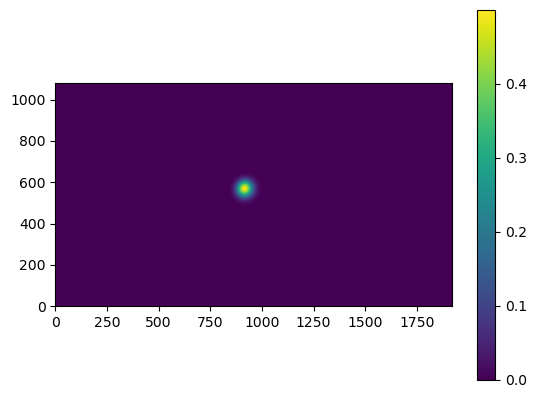

In [284]:
plt.imshow(spec, origin='lower')
plt.colorbar()

In [ ]:
spe

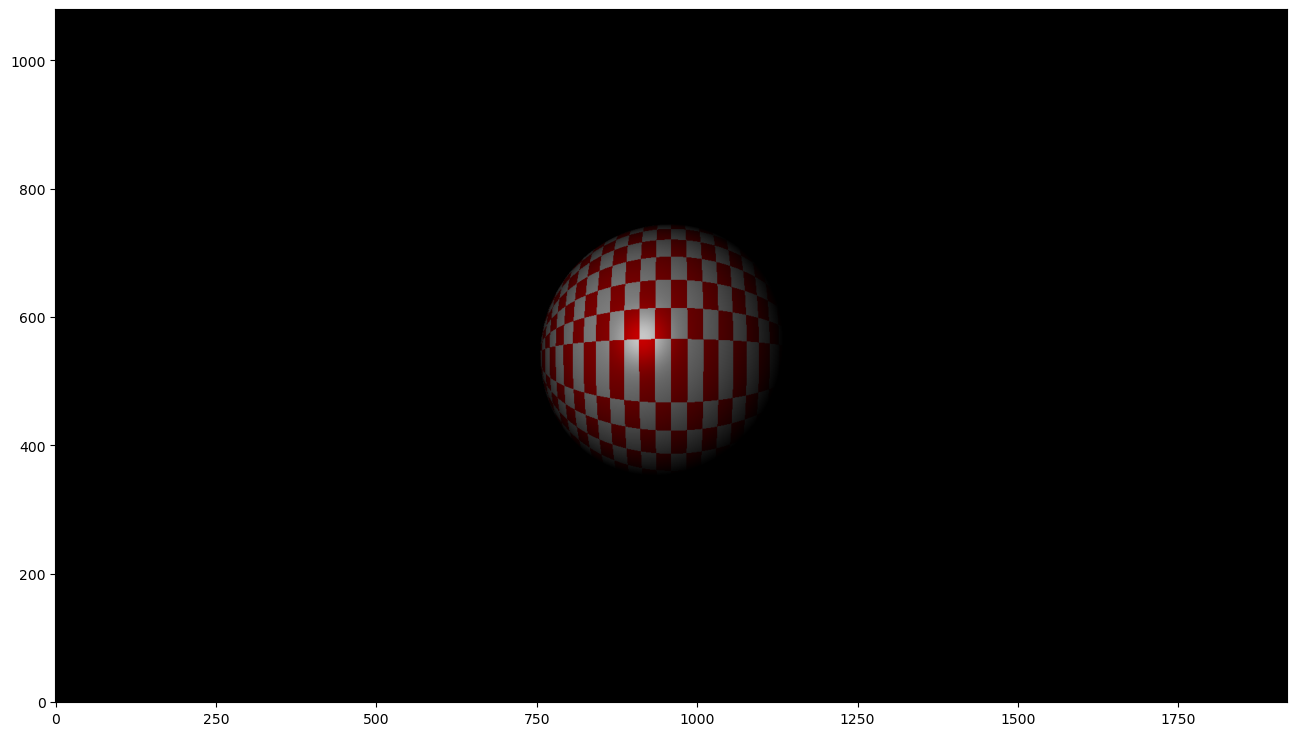

In [285]:
ls_intensity = 1
final_color = ls_intensity * diffusion_factor[...,None]*sphere_color + spec[...,None] * 1.2 * sphere_color
final_color = np.clip(final_color, 0, 255)

plt.figure(figsize=(16,9))
plt.imshow(final_color.astype(np.uint8), origin='lower')